# CARS recommender system
Implementation of the deep NN model described in the paper "Context-Aware Recommendations Based on Deep
Learning Frameworks".
https://dl.acm.org/doi/10.1145/3386243

Datasets:
- frappe


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('frappe/frappe.csv', sep="\t")
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


## Dataset preprocessing

In [3]:
# log transformation on the raw frequency numbers represents the application usage
df['cnt'] = df['cnt'].apply(np.log10)
f"frequency range is {df['cnt'][df['cnt'] == df['cnt'].min()].values[0]} to {df['cnt'][df['cnt'] == df['cnt'].max()].values[0]}"

'frequency range is 0.0 to 4.458668059764898'

In [4]:
# delete columns that are not needed
del df['homework']
del df['cost']
del df['country']

In [5]:
# change column type to category and convert categorical data to integers
for col in ['daytime', 'weekday', 'isweekend', 'weather']:
    df[col] = df[col].astype('category').cat.codes.values
df.head()

,user,item,cnt,daytime,weekday,isweekend,weather,city
0,0,0,0.000000,2,3,0,7,0
1,1,1,0.845098,0,2,0,0,0
2,2,2,0.778151,1,1,1,0,369
3,3,3,0.000000,6,4,1,8,1028
4,4,4,2.631444,3,4,1,7,147


In [6]:
# train and test datasets
train_x, test_x = train_test_split(df, test_size=0.2)

# train and test context features
train_context = pd.concat([train_x.pop(x) for x in ['daytime', 'weekday', 'isweekend', 'weather', 'city']], axis=1)
test_context = pd.concat([test_x.pop(x) for x in ['daytime', 'weekday', 'isweekend', 'weather', 'city']], axis=1)

# train and test labels
train_y = train_x.pop('cnt')
test_y = test_x.pop('cnt')

f"train_x: {train_x.shape}   train_y: {train_y.shape}   test_x: {test_x.shape}   test_y: {test_y.shape}   train_context: {train_context.shape}   test_context:   {test_context.shape}"    

'train_x: (76962, 2)   train_y: (76962,)   test_x: (19241, 2)   test_y: (19241,)   train_context: (76962, 5)   test_context:   (19241, 5)'

In [7]:
n_latent_factors = 10

# count unique user and item
n_users, n_items = len(df.user.unique()), len(df.item.unique())
f'Number of users: {n_users}      Number of apps: {n_items}'


'Number of users: 957      Number of apps: 4082'

## The model

In [11]:
# inputs
item_input = keras.layers.Input(shape=[1],name='item')
user_input = keras.layers.Input(shape=[1],name='user')
context_input = keras.layers.Input(shape=(5,), name='context')

# Item embedding
item_embedding_mlp = keras.layers.Embedding(n_items + 1, n_latent_factors, name='item_embedding')(item_input)
item_vec_mlp = keras.layers.Flatten(name='flatten_item')(item_embedding_mlp)

# User embedding
user_vec_mlp = keras.layers.Flatten(name='flatten_user')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='users_embedding')(user_input))

# Concat user embedding,item embeddings and context vector
concat = tf.keras.layers.Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp, context_input])

# dense layers
dense = keras.layers.Dense(64,name='fully_connected_1')(concat)
dense_2 = keras.layers.Dense(32,name='fully_connected_2')(dense)
dense_3 = keras.layers.Dense(16,name='fully_connected_3')(dense_2)

# Output
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_3)

# make and build the model
mlp = keras.Model([user_input, item_input, context_input], pred_mlp)
mlp.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae', 'mse'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        40830       item[0][0]                       
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 10)        9580        user[0][0]                       
____________________________________________________________________________________________

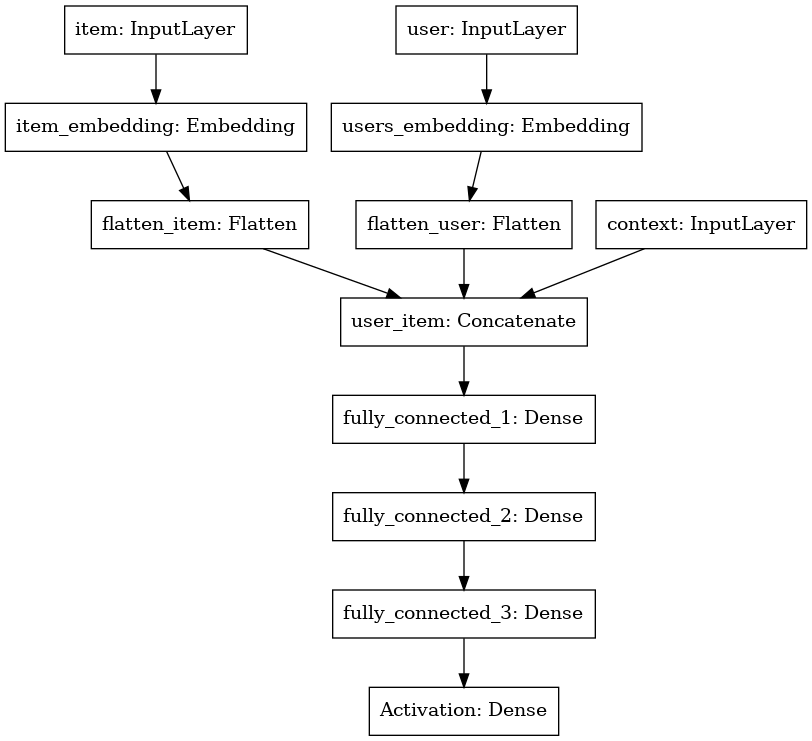

In [12]:
mlp.summary()
tf.keras.utils.plot_model(mlp)

In [10]:
history = mlp.fit([train_x.user, train_x.item, train_context], train_y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
1203/1203 [==============================] - 7s 6ms/step - loss: 1.1980 - mae: 1.1980 - mse: 37.2333
Epoch 2/10
1203/1203 [==============================] - 4s 4ms/step - loss: 0.9820 - mae: 0.9820 - mse: 1.6715
Epoch 3/10
1203/1203 [==============================] - 5s 4ms/step - loss: 0.9820 - mae: 0.9820 - mse: 1.6715
Epoch 4/10
 262/1203 [=====>........................] - ETA: 10s - loss: 0.9696 - mae: 0.9696 - mse: 1.6365

KeyboardInterrupt: 

In [120]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

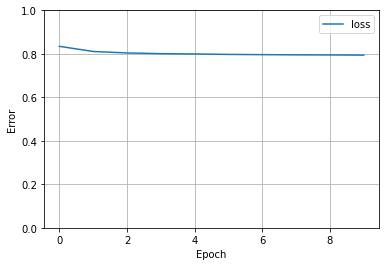

In [121]:
plot_loss(history)

In [122]:
results = mlp.evaluate((test_x.user, test_x.item, test_context), test_y, batch_size=1)

19241/19241 [==============================] - 38s 2ms/step - loss: 0.8100 - mae: 0.8100 - mse: 1.2335


In [123]:
test_predictions = mlp.predict([test_x.user, test_x.item, test_context]).flatten()

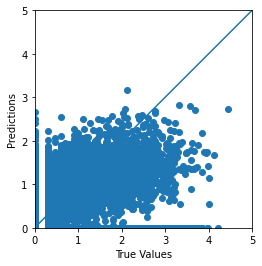

In [124]:
a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)